# Problem 1 — SOFR Caps and Hull–White Calibration

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.stats import norm
from scipy.interpolate import interp1d
import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

# Constants and paths (assumes this notebook lives in the same folder as the CSV files)
SETTLEMENT_DATE = datetime.datetime.strptime("2023-04-17", "%Y-%m-%d").date()
TRADE_DATE = datetime.datetime.strptime("2023-04-13", "%Y-%m-%d").date()
MATURITIES_Y = [1,2,3,4,5,6,7,8,9,10,12,15,20,25,30]


In [4]:
# Load data (local CSVs)
BASE_DIR = '.'
accrual_df = pd.read_csv(f'{BASE_DIR}/P_caplet_accruals_20230413.csv', names=['accrual_dfs'])
payment_df = pd.read_csv(f'{BASE_DIR}/P_caplet_payments_20230413.csv', names=['payment_dfs'])
swap_df = pd.read_csv(f'{BASE_DIR}/cap_sofr_atm_strikes_20230413.csv', names=['BBG_swap_rates'])
bachelier_vols = pd.read_csv(f'{BASE_DIR}/cap_sofr_atm_bachelier_vols_20230413.csv', names=['bachelier_vols'])
sofr_caps = pd.read_csv(f'{BASE_DIR}/sofr_cap_bloomberg_pv_20230413.csv', names=['BBG_sofr_caps'])

swap_df['bachelier_vols'] = bachelier_vols['bachelier_vols']/10000
swap_df['BBG_sofr_caps'] = sofr_caps['BBG_sofr_caps']


In [5]:
# Calendar and date helper functions

def adjust_to_us_business_day(date):
    """
    Adjusts a date forward to the next business day, skipping weekends and US federal holidays.
    """
    cal = USFederalHolidayCalendar()
    # Look a few days before and after for holidays
    holidays = cal.holidays(start=date - pd.Timedelta(days=1), end=date + pd.Timedelta(days=10)).to_pydatetime()
    while date.weekday() >= 5 or any(date == h.date() for h in holidays):
        date += pd.Timedelta(days=1)
    return date

def days_actual(start, end):
    """
    Returns the number of days between two datetime or date objects.
    """
    return int((end - start).days)

def get_payment_date(accrual_end_date):
    """
    Returns the payment date, which is two business days after the accrual end date.
    """
    payment = accrual_end_date
    for _ in range(2):
        payment = adjust_to_us_business_day(payment + pd.Timedelta(days=1))
    return payment

def get_discount_factor_by_payment_date(date, payment_df=payment_df):
    """
    Returns the discount factor for a given payment date.
    """
    row = payment_df[payment_df['payment_date'] == date]
    if not row.empty:
        return row['payment_dfs'].values[0]
    raise ValueError(f"Payment date {date} not found in payment_df.")

def get_discount_factor_by_accrual_date(date, accrual_df=accrual_df):
    """
    Returns the discount factor for a given accrual date.
    """
    row = accrual_df[accrual_df['accrual_date'] == date]
    if not row.empty:
        return row['accrual_dfs'].values[0]
    raise ValueError(f"Accrual date {date} not found in accrual_df.")

def compute_forward_rate(start_date, end_date):
    """
    Calculates the forward rate between two dates using discount factors and ACT/360 convention.
    """
    df_start = get_discount_factor_by_accrual_date(start_date)
    df_end = get_discount_factor_by_accrual_date(end_date)
    tau = days_actual(start_date, end_date) / 360
    return (df_start / df_end - 1) / tau

def compute_par_swap_rate(_trade_date, settlement_date, maturity, frequency='3M'):
    """
    Calculates the par swap rate for a given maturity and frequency.
    """
    freq_months = int(frequency.replace('M', ''))
    n_periods = int(maturity * 12 / freq_months)
    fixed_leg = 0.0
    floating_leg = 0.0
    for i in range(1, n_periods + 1):
        period_end = adjust_to_us_business_day(settlement_date + relativedelta(months=i * freq_months))
        period_start = adjust_to_us_business_day(settlement_date + relativedelta(months=(i - 1) * freq_months))
        pay_date = get_payment_date(period_end)
        df = get_discount_factor_by_payment_date(pay_date)
        tau = days_actual(period_start, period_end) / 360
        fwd_rate = compute_forward_rate(period_start, period_end)
        fixed_leg += df * tau
        floating_leg += df * fwd_rate * tau
    return floating_leg / fixed_leg if fixed_leg != 0 else np.nan


In [6]:
# Build schedules, forward rates table, and proxy times (T_onethird)
accrual_dates = [adjust_to_us_business_day(SETTLEMENT_DATE)]
payment_dates = []

# Build accrual and payment dates for 120 periods (10 years, quarterly)
for i in range(1, 121):
    accrual_dt = adjust_to_us_business_day(SETTLEMENT_DATE + relativedelta(months=i*3))
    accrual_dates.append(accrual_dt)
    payment_dates.append(get_payment_date(accrual_dt))

# Assign to DataFrames
accrual_df['accrual_date'] = accrual_dates
payment_df['payment_date'] = payment_dates

# Initialize columns
payment_df['accrual_period_start_date'] = [None] * 120
payment_df['accrual_period_end_date'] = [None] * 120
payment_df['tau'] = np.nan
payment_df['F_sofr'] = np.nan
payment_df['T'] = np.nan
payment_df['T_onethird'] = np.nan

# Fill in schedule and forward rate info
for i in range(120):
    start_date = accrual_dates[i]
    end_date = accrual_dates[i+1]
    payment_df.at[i, 'accrual_period_start_date'] = start_date
    payment_df.at[i, 'accrual_period_end_date'] = end_date
    payment_df.at[i, 'tau'] = days_actual(start_date, end_date) / 360
    payment_df.at[i, 'F_sofr'] = compute_forward_rate(start_date, end_date)
    payment_df.at[i, 'T'] = days_actual(accrual_dates[0], end_date) / 365
    if i > 0:
        prev_T = payment_df.at[i-1, 'T']
        curr_T = payment_df.at[i, 'T']
        payment_df.at[i, 'T_onethird'] = prev_T + (curr_T - prev_T) / 3
    else:
        payment_df.at[i, 'T_onethird'] = payment_df.at[i, 'T'] / 3

payment_df.head()


,payment_dfs,payment_date,accrual_period_start_date,accrual_period_end_date,tau,F_sofr,T,T_onethird
0,0.987296,2023-07-19,2023-04-17,2023-07-17,0.252778,0.049815,0.249315,0.083105
1,0.975209,2023-10-19,2023-07-17,2023-10-17,0.255556,0.048557,0.501370,0.333333
2,0.964098,2024-01-19,2023-10-17,2024-01-17,0.255556,0.045185,0.753425,0.585388
3,0.954201,2024-04-19,2024-01-17,2024-04-17,0.252778,0.041206,1.002740,0.836530
4,0.945931,2024-07-19,2024-04-17,2024-07-17,0.252778,0.034588,1.252055,1.085845


In [7]:
# Compute swap rates and compare to Bloomberg ATM strikes
swap_df['maturity'] = MATURITIES_Y
swap_df['trade_date'] = TRADE_DATE
swap_df['settlement_date'] = SETTLEMENT_DATE
swap_df['calculated_swap_rate'] = 0.0
for i in range(len(swap_df)):
    a, b, c = swap_df.loc[i, 'trade_date'], swap_df.loc[i, 'settlement_date'], swap_df.loc[i, 'maturity']
    swap_df.loc[i, 'calculated_swap_rate'] = compute_par_swap_rate(a, b, c)

swap_df['swap_rate_error'] = swap_df['calculated_swap_rate'] - swap_df['BBG_swap_rates']
swap_df.head()


,BBG_swap_rates,bachelier_vols,BBG_sofr_caps,maturity,trade_date,settlement_date,calculated_swap_rate,swap_rate_error
0,0.046236,0.013470,36506.60,1,2023-04-13,2023-04-17,0.046236,-2.428613e-16
1,0.039285,0.015087,126827.94,2,2023-04-13,2023-04-17,0.039285,-6.314393e-16
2,0.035581,0.014576,219856.39,3,2023-04-13,2023-04-17,0.035581,1.318390e-16
3,0.033578,0.013871,311461.71,4,2023-04-13,2023-04-17,0.033578,-1.595946e-16
4,0.032458,0.013238,400915.46,5,2023-04-13,2023-04-17,0.032458,1.110223e-16


In [8]:
# Bachelier cap pricing (Problem 1d)

def bachelier_caplet_price(F, K, sigma, T, w=1):
    """Price a single caplet using the Bachelier (normal) model."""
    if sigma <= 0 or T <= 0:
        return max(w * (F - K), 0.0)
    d = w * (F - K) / (sigma * np.sqrt(T))
    return sigma * np.sqrt(T) * norm.pdf(d) + w * (F - K) * norm.cdf(d)

def calculate_bachelier_cap_price(maturity, sigma, K, payment_df, frequency='3M', notional=10_000_000):
    """Compute the price of a cap using the Bachelier model for all caplets up to given maturity."""
    freq_months = int(frequency.replace('M', ''))
    n_periods = int(maturity * 12 / freq_months)
    cap_price = 0.0
    for i in range(n_periods):
        F = payment_df.at[i, 'F_sofr']
        tau = payment_df.at[i, 'tau']
        T = payment_df.at[i, 'T_onethird']
        df = payment_df.at[i, 'payment_dfs']
        caplet_price = bachelier_caplet_price(F, K, sigma, T)
        cap_price += caplet_price * df * tau
    return notional * cap_price

# Calculate Bachelier cap prices for each swap maturity
swap_df['calculated_cap_price'] = [
    calculate_bachelier_cap_price(
        maturity=row['maturity'],
        sigma=row['bachelier_vols'],
        K=row['calculated_swap_rate'],
        payment_df=payment_df
    )
    for _, row in swap_df.iterrows()
]

swap_df['cap_price_error'] = swap_df['calculated_cap_price'] - swap_df['BBG_sofr_caps']
swap_df.head()


,BBG_swap_rates,bachelier_vols,BBG_sofr_caps,maturity,trade_date,settlement_date,calculated_swap_rate,swap_rate_error,calculated_cap_price,cap_price_error
0,0.046236,0.013470,36506.60,1,2023-04-13,2023-04-17,0.046236,-2.428613e-16,36487.366793,-19.233207
1,0.039285,0.015087,126827.94,2,2023-04-13,2023-04-17,0.039285,-6.314393e-16,126820.346849,-7.593151
2,0.035581,0.014576,219856.39,3,2023-04-13,2023-04-17,0.035581,1.318390e-16,219963.656209,107.266209
3,0.033578,0.013871,311461.71,4,2023-04-13,2023-04-17,0.033578,-1.595946e-16,311516.400428,54.690428
4,0.032458,0.013238,400915.46,5,2023-04-13,2023-04-17,0.032458,1.110223e-16,400902.838978,-12.621022


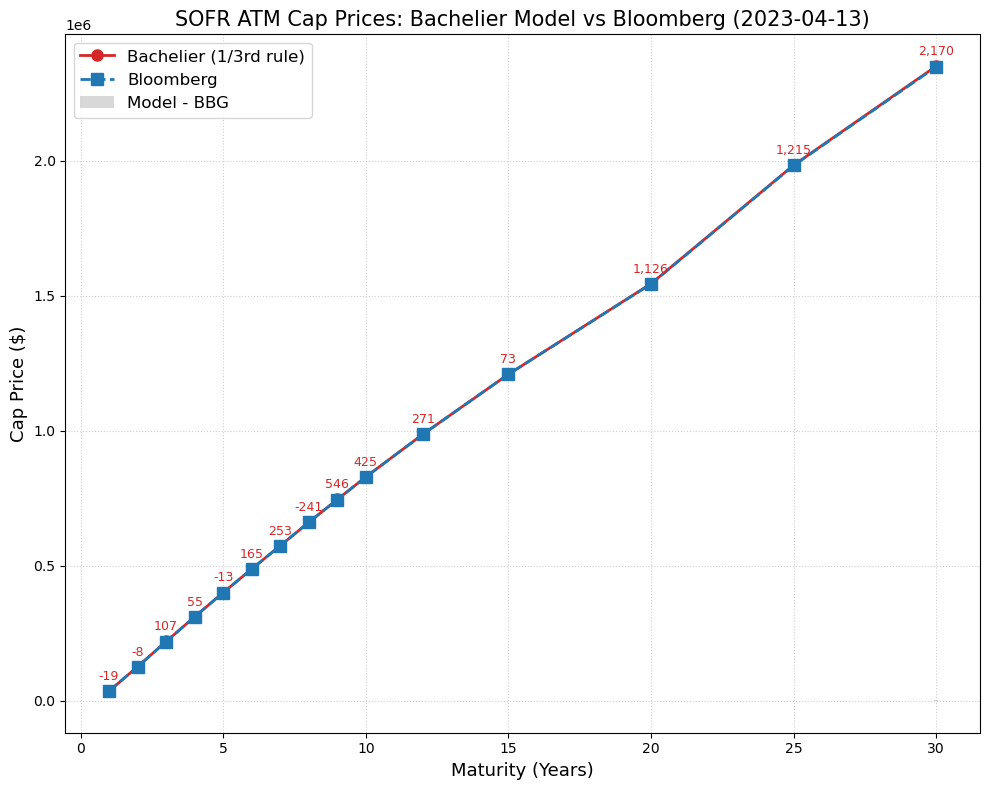

In [9]:
# Bachelier vs Bloomberg cap prices with error bars and grid
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Bachelier model prices
ax.plot(
    swap_df['maturity'],
    swap_df['calculated_cap_price'],
    marker='o',
    color='tab:red',
    linestyle='-',
    linewidth=2,
    markersize=8,
    label='Bachelier (1/3rd rule)'
)

# Plot Bloomberg prices
ax.plot(
    swap_df['maturity'],
    swap_df['BBG_sofr_caps'],
    marker='s',
    color='tab:blue',
    linestyle='--',
    linewidth=2,
    markersize=8,
    label='Bloomberg'
)

# Highlight the difference as bars
ax.bar(
    swap_df['maturity'],
    swap_df['calculated_cap_price'] - swap_df['BBG_sofr_caps'],
    width=0.15,
    color='gray',
    alpha=0.3,
    label='Model - BBG'
)

# Annotate the absolute error above each bar
for x, model, bbg in zip(swap_df['maturity'], swap_df['calculated_cap_price'], swap_df['BBG_sofr_caps']):
    diff = model - bbg
    ax.annotate(f"{diff:,.0f}", (x, model), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color='tab:red')

ax.set_xlabel('Maturity (Years)', fontsize=13)
ax.set_ylabel('Cap Price ($)', fontsize=13)
ax.set_title('SOFR ATM Cap Prices: Bachelier Model vs Bloomberg (2023-04-13)', fontsize=15)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
# Hull–White cap pricing and calibration (Problem 1e)

def hull_white_caplet_price(p_pmt_start, p_pmt_end, p_acc_start, p_acc_end, tau, strike, sigma_p):
    """
    Price a single caplet under the Hull-White 1F model using the Jamshidian decomposition.
    """
    if sigma_p <= 0:
        # Avoid division by zero or negative vol
        return max(p_pmt_start - (1 + strike * tau) * p_pmt_end, 0.0)
    h = (1 / sigma_p) * np.log((p_acc_end * (1 + strike * tau)) / p_acc_start) + sigma_p / 2
    price = p_pmt_start * norm.cdf(-h + sigma_p) - (1 + strike * tau) * p_pmt_end * norm.cdf(-h)
    return price

def calculate_sigma_p(kappa, sigma, t0, t1, t2):
    """
    Compute the standard deviation of the integral of the short rate over [t1, t2] under Hull-White.
    """
    dt = t2 - t1
    if kappa <= 0 or sigma <= 0 or dt <= 0:
        return 0.0
    exp_kdt = np.exp(-kappa * dt)
    exp_2kt1 = np.exp(-2 * kappa * (t1 - t0))
    term1 = ((1 - exp_kdt) / kappa) ** 2 * (sigma ** 2 / (2 * kappa)) * (1 - exp_2kt1)
    term2 = (sigma ** 2) / (kappa ** 2) * (
        dt + 2 / kappa * exp_kdt - (1 / (2 * kappa)) * np.exp(-2 * kappa * dt) - 3 / (2 * kappa)
    )
    sigma_p2 = term1 + term2
    return np.sqrt(np.maximum(sigma_p2, 0.0))

def calculate_hull_white_cap_price(params, payment_df, accrual_df, maturity, strike, frequency='3M'):
    """
    Price a cap as a sum of Hull-White caplets.
    """
    kappa, sigma = params
    freq_months = int(frequency.replace('M', ''))
    n_periods = int(maturity * 12 / freq_months)
    cap_price = 0.0
    t0 = 0.0
    for i in range(n_periods):
        if i == 0:
            p_pmt_start = accrual_df['accrual_dfs'].iloc[i]
            p_acc_start = accrual_df['accrual_dfs'].iloc[i]
            t1 = 0.0
        else:
            p_pmt_start = payment_df['payment_dfs'].iloc[i - 1]
            p_acc_start = accrual_df['accrual_dfs'].iloc[i]
            t1 = payment_df['T'].iloc[i - 1]
        p_pmt_end = payment_df['payment_dfs'].iloc[i]
        p_acc_end = accrual_df['accrual_dfs'].iloc[i + 1]
        tau = payment_df['tau'].iloc[i]
        t2 = payment_df['T'].iloc[i]
        sigma_p = calculate_sigma_p(kappa, sigma, t0, t1, t2)
        caplet_price = hull_white_caplet_price(
            p_pmt_start, p_pmt_end, p_acc_start, p_acc_end, tau, strike, sigma_p
        )
        cap_price += caplet_price
    return cap_price

def _hull_white_residuals(params, swap_df, payment_df, accrual_df):
    """
    Objective function: difference between model and market cap prices (normalized).
    """
    residuals = []
    for _, row in swap_df.iterrows():
        maturity = row['maturity']
        strike = row['calculated_swap_rate']
        model_price = calculate_hull_white_cap_price(params, payment_df, accrual_df, maturity, strike, '3M')
        market_price = row['calculated_cap_price'] / 10_000_000
        residuals.append(model_price - market_price)
    return np.array(residuals)

def fit_hull_white_kappa_sigma(swap_df, payment_df, accrual_df):
    """
    Calibrate Hull-White (kappa, sigma) to cap prices using least squares.
    """
    from scipy.optimize import least_squares
    x0 = [0.01, 0.01]
    bounds = ([0.001, 0.001], [0.5, 0.5])
    result = least_squares(
        _hull_white_residuals, x0=x0,
        args=(swap_df, payment_df, accrual_df),
        bounds=bounds, verbose=2
    )
    return tuple(result.x)

kappa, sigma = fit_hull_white_kappa_sigma(swap_df, payment_df, accrual_df)
print('kappa:', kappa)
print('sigma:', sigma)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7513e-04                                    1.44e-02    
       1              2         1.6250e-04      3.13e-04       3.04e-02       3.67e-03    
       2              3         9.4168e-05      6.83e-05       2.26e-02       1.23e-03    
       3              4         8.5684e-05      8.48e-06       1.03e-02       2.48e-04    
       4              5         8.5102e-05      5.82e-07       3.22e-03       3.21e-05    
       5              6         8.5086e-05      1.68e-08       5.82e-04       3.31e-06    
       6              7         8.5085e-05      3.31e-10       8.29e-05       3.99e-07    
       7              8         8.5085e-05      5.94e-12       1.11e-05       5.16e-08    
       8              9         8.5085e-05      1.09e-13       1.45e-06       2.41e-09    
`gtol` termination condition is satisfied.
Function evaluations 9, initial cost 4.7513e-04

In [11]:
# Price caps with fitted Hull–White and compare
for i in range(len(swap_df)):
    mat, K = swap_df.loc[i, 'maturity'], swap_df.loc[i, 'calculated_swap_rate']
    x = [kappa, sigma]
    swap_df.loc[i, 'calculated_hull_white_cap_price'] = 10_000_000 * calculate_hull_white_cap_price(x, payment_df, accrual_df, mat, K, frequency='3M')

swap_df['cap_price_hull_white_error'] = swap_df['calculated_hull_white_cap_price'] - swap_df['BBG_sofr_caps']
swap_df.head()


,BBG_swap_rates,bachelier_vols,BBG_sofr_caps,maturity,trade_date,settlement_date,calculated_swap_rate,swap_rate_error,calculated_cap_price,cap_price_error,calculated_hull_white_cap_price,cap_price_hull_white_error
0,0.046236,0.013470,36506.60,1,2023-04-13,2023-04-17,0.046236,-2.428613e-16,36487.366793,-19.233207,37685.149440,1178.549440
1,0.039285,0.015087,126827.94,2,2023-04-13,2023-04-17,0.039285,-6.314393e-16,126820.346849,-7.593151,116071.145822,-10756.794178
2,0.035581,0.014576,219856.39,3,2023-04-13,2023-04-17,0.035581,1.318390e-16,219963.656209,107.266209,199588.867529,-20267.522471
3,0.033578,0.013871,311461.71,4,2023-04-13,2023-04-17,0.033578,-1.595946e-16,311516.400428,54.690428,284936.400118,-26525.309882
4,0.032458,0.013238,400915.46,5,2023-04-13,2023-04-17,0.032458,1.110223e-16,400902.838978,-12.621022,372023.901400,-28891.558600


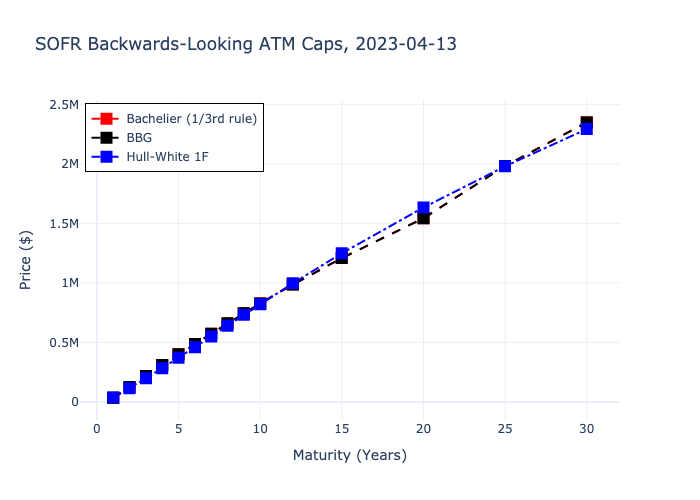

In [12]:
# Plot: Bachelier vs Bloomberg vs Hull–White
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=swap_df['maturity'],
    y=swap_df['calculated_cap_price'],
    mode='lines+markers',
    name='Bachelier (1/3rd rule)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='square', size=10, color='red', line=dict(width=2, color='red')),
)
)

fig.add_trace(go.Scatter(
    x=swap_df['maturity'],
    y=swap_df['BBG_sofr_caps'],
    mode='lines+markers',
    name='BBG',
    line=dict(color='black', dash='dash'),
    marker=dict(symbol='square', size=10, color='black', line=dict(width=2, color='black')),
)
)

fig.add_trace(go.Scatter(
    x=swap_df['maturity'],
    y=swap_df['calculated_hull_white_cap_price'],
    mode='lines+markers',
    name='Hull-White 1F',
    line=dict(color='blue', dash='dashdot'),
    marker=dict(symbol='square', size=10, color='blue', line=dict(width=2, color='blue')),
)
)

fig.update_layout(
    title='SOFR Backwards-Looking ATM Caps, 2023-04-13',
    xaxis_title='Maturity (Years)',
    yaxis_title='Price ($)',
    legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1),
    template='plotly_white'
)

fig.show(renderer='png')


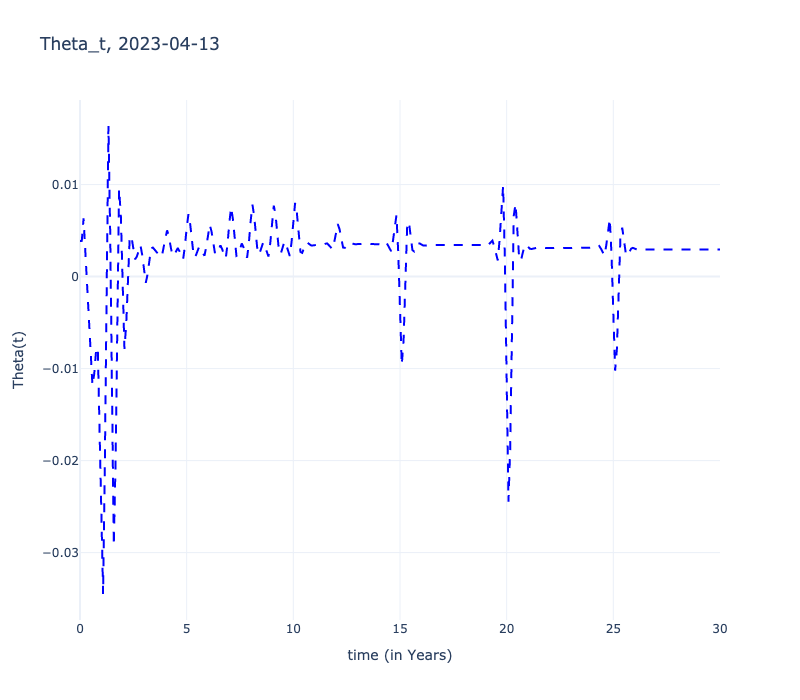

In [13]:
# Compute monthly θ(t) (Problem 1f)

def fit_hull_white_theta_t(monthly_grid, fwd_rates, dfwd_dt, kappa, sigma):
    term1 = dfwd_dt
    term2 = kappa * fwd_rates
    term3 = (sigma**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * monthly_grid))
    return term1 + term2 + term3

payment_years = np.insert(payment_df['T'], 0, 0)
monthly_grid = np.arange(0, payment_years.max(), 1/12)

# Interpolate DFs to monthly grid using cubic spline on accrual DFs
spline = interp1d(payment_years, accrual_df['accrual_dfs'], kind='cubic', fill_value='extrapolate')
monthly_dfs = spline(monthly_grid)

# Instantaneous forwards and their derivative
fwd_rates = -(np.log(monthly_dfs[1:]) - np.log(monthly_dfs[:-1])) / np.diff(monthly_grid)
fwd_rates = np.insert(fwd_rates, 0, fwd_rates[0])
dfwd_dt = np.diff(fwd_rates) / np.diff(monthly_grid)
dfwd_dt = np.insert(dfwd_dt, 0, dfwd_dt[0])

theta_t = fit_hull_white_theta_t(monthly_grid, fwd_rates, dfwd_dt, kappa, sigma)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=monthly_grid,
    y=theta_t,
    mode='lines',
    name='Hull-White theta',
    line=dict(color='blue', dash='dash')
))
fig.update_layout(
    title='Theta_t, 2023-04-13',
    xaxis_title='time (in Years)',
    yaxis_title='Theta(t)',
    width=800,
    height=700,
    template='plotly_white',
    legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1)
)
fig.show(renderer='png')


# Problem 2: Pricing REMIC Bonds

In [ ]:
# Parameters from the prospectus and previous computations
REMIC_PARAMS = {
    "SEED": 0,
    "N_PATHS_TOTAL": 10_000,
    "T_MONTHS": 360,
    "BASIS": 12.0,
    "KAPPA": kappa,
    "SIGMA": sigma,
    "R0": payment_df.iloc[0]['F_sofr'],
    "THETA": theta_t,
    "ORIG_BAL": 94_894_021.00,
    "WAC": 0.0747,
    "SERV": 0.0097,
    "WAM": 354,
    "BETA": 0.38089,
    "PSA_MULT": 2.5,
    "PSA_STEP": 0.002,
    "MAX_RAMP": 30,
    "FA_SPREAD": 0.0092,   # FA = SOFR + 0.92%
    "SA_CAP": 0.0558,      # SA = 5.58% - SOFR
}

REMIC_PARAMS["NOTE_NET"] = REMIC_PARAMS["WAC"] - REMIC_PARAMS["SERV"]
rng = np.random.default_rng(REMIC_PARAMS["SEED"])

In [ ]:
class REMICGroup2Pricer:
    def __init__(self, params, rng=None):
        self.params = params
        self.rng = rng if rng is not None else np.random.default_rng(params["SEED"])

    def simulate_hull_white_paths_antithetic(
        self, n_paths_total, T_months, kappa, sigma, r0, theta_monthly=None
    ):
        """
        Simulate Hull-White short rate paths and discount factors using Euler discretization
        with antithetic variates. Returns (r_paths, disc_paths) of shape (n_paths, T).
        """
        assert n_paths_total % 2 == 0, "n_paths_total must be even for antithetic variates"
        dt = 1.0 / self.params["BASIS"]
        steps = T_months
        if theta_monthly is None:
            theta = np.full(steps, kappa * r0, dtype=float)
        else:
            theta = np.asarray(theta_monthly, dtype=float)
            assert len(theta) >= steps
            theta = theta[:steps]
        half = n_paths_total // 2
        Z = self.rng.standard_normal(size=(half, steps))
        Z = np.vstack([Z, -Z])  # antithetic
        r = np.empty((n_paths_total, steps))
        disc = np.empty((n_paths_total, steps))
        # Initial step
        r[:, 0] = r0 + (theta[0] - kappa * r0) * dt + sigma * np.sqrt(dt) * Z[:, 0]
        disc[:, 0] = np.exp(-r[:, 0] * dt)
        for t in range(1, steps):
            r[:, t] = (
                r[:, t - 1]
                + (theta[t] - kappa * r[:, t - 1]) * dt
                + sigma * np.sqrt(dt) * Z[:, t]
            )
            disc[:, t] = disc[:, t - 1] * np.exp(-r[:, t] * dt)
        return r, disc

    def calculate_level_payment(self, balance, rate_annual, n_months):
        if n_months <= 0:
            return 0.0
        rm = rate_annual / self.params["BASIS"]
        if rm == 0:
            return balance / n_months
        return balance * rm / (1.0 - (1.0 + rm) ** (-n_months))

    def scheduled_principal_and_interest(self, prev_balance, rate_annual, n_remaining):
        pmt = self.calculate_level_payment(prev_balance, rate_annual, n_remaining)
        interest = prev_balance * (rate_annual / self.params["BASIS"])
        principal = max(pmt - interest, 0.0)
        return principal, interest

    def annual_cpr_psa_250(self, pool_month, wam):
        ramp = min(pool_month + (360 - wam), self.params["MAX_RAMP"])
        return self.params["PSA_MULT"] * (self.params["PSA_STEP"] * ramp)  # annual CPR

    def smm_from_cpr(self, cpr):
        return 1.0 - (1.0 - cpr) ** (1.0 / 12.0)

    def effective_smm(self, pool_month, wam, short_rate_now, contract_rate=None):
        if contract_rate is None:
            contract_rate = self.params["WAC"]
        smm_250 = self.smm_from_cpr(self.annual_cpr_psa_250(pool_month, wam))
        ten_y = short_rate_now
        x_t = contract_rate - ten_y
        smm = smm_250 * np.exp(self.params["BETA"] * x_t)
        return float(np.clip(smm, 0.0, 1.0))

    def price_fa_sa_tranches(
        self,
        r_paths,
        disc_paths,
        orig_balance=None,
        wam=None,
        note_net=None,
        fa_spread=None,
        sa_cap=None,
    ):
        """
        Price the FA and SA tranches for REMIC Group 2 using simulated paths.
        Returns (fa_val, sa_val) arrays of shape (n_paths,).
        """
        if orig_balance is None:
            orig_balance = self.params["ORIG_BAL"]
        if wam is None:
            wam = self.params["WAM"]
        if note_net is None:
            note_net = self.params["NOTE_NET"]
        if fa_spread is None:
            fa_spread = self.params["FA_SPREAD"]
        if sa_cap is None:
            sa_cap = self.params["SA_CAP"]

        n_paths, steps = r_paths.shape
        fa_val = np.zeros(n_paths)
        sa_val = np.zeros(n_paths)
        for p in range(n_paths):
            bal = orig_balance
            n_rem = wam
            tmax = min(steps, wam)
            cf_fa = []
            cf_sa = []
            for m in range(1, tmax + 1):
                sched_prin, _ = self.scheduled_principal_and_interest(bal, note_net, n_rem)
                smm = self.effective_smm(m, wam, r_paths[p, m - 1])
                prepay = smm * max(bal - sched_prin, 0.0)
                total_prin = sched_prin + prepay
                next_bal = max(bal - total_prin, 0.0)
                sofr = r_paths[p, m - 1]
                fa_int = (sofr / self.params["BASIS"] + fa_spread / self.params["BASIS"]) * bal
                sa_int = (sa_cap / self.params["BASIS"] - sofr / self.params["BASIS"]) * bal
                cf_fa.append(total_prin + fa_int)
                cf_sa.append(sa_int)
                bal = next_bal
                n_rem = max(n_rem - 1, 0)
                if bal <= 1e-9 or n_rem == 0:
                    break
            if cf_fa:
                idxs = np.arange(len(cf_fa))
                fa_val[p] = float(np.sum(np.array(cf_fa) * disc_paths[p, idxs]))
                sa_val[p] = float(np.sum(np.array(cf_sa) * disc_paths[p, idxs]))
        return fa_val, sa_val

    def summarize_pv(self, pvs, notional):
        mean_pv = float(np.mean(pvs))
        std_pv = float(np.std(pvs, ddof=1))
        se_100 = 100.0 * (std_pv / np.sqrt(len(pvs)) / notional)
        price_100 = 100.0 * (mean_pv / notional)
        return mean_pv, price_100, se_100

    def apply_option_adjusted_spread(self, disc_paths, oas_annual):
        dt = 1.0 / self.params["BASIS"]
        steps = disc_paths.shape[1]
        t_idx = np.arange(1, steps + 1, dtype=float)
        adj = np.exp(-oas_annual * dt * t_idx)[None, :]
        return disc_paths * adj

    def solve_oas_to_par_price(
        self,
        r_paths,
        disc_paths,
        target_pv,
        type="FA",
        lo=-0.05,
        hi=0.05,
        tol=1e-7,
        iters=64,
    ):
        """
        Solve for the OAS (option-adjusted spread) that makes the mean PV equal to target_pv.
        """
        def price_at(oas):
            dp = self.apply_option_adjusted_spread(disc_paths, oas)
            fa_pv, sa_pv = self.price_fa_sa_tranches(r_paths, dp)
            mean_pv = float(np.mean(fa_pv if type.upper() == "FA" else sa_pv))
            return mean_pv

        f_lo = price_at(lo) - target_pv
        f_hi = price_at(hi) - target_pv
        expand = 0
        while f_lo * f_hi > 0 and expand < 8:
            lo *= 2.0
            hi *= 2.0
            f_lo = price_at(lo) - target_pv
            f_hi = price_at(hi) - target_pv
            expand += 1
        if f_lo * f_hi > 0:
            return float("nan")
        for _ in range(iters):
            mid = 0.5 * (lo + hi)
            f_mid = price_at(mid) - target_pv
            if abs(f_mid) < tol:
                return mid
            if f_lo * f_mid <= 0:
                hi, f_hi = mid, f_mid
            else:
                lo, f_lo = mid, f_mid
        return 0.5 * (lo + hi)

# Instantiate and run the pricer
pricer = REMICGroup2Pricer(REMIC_PARAMS, rng=rng)

print(f"HW params from Problem 1: kappa={REMIC_PARAMS['KAPPA']:.6f}, sigma={REMIC_PARAMS['SIGMA']:.6f}, r0={REMIC_PARAMS['R0']:.6f}, theta={'monthly' if REMIC_PARAMS['THETA'] is not None else 'constant'}")

r_paths, disc_paths = pricer.simulate_hull_white_paths_antithetic(
    REMIC_PARAMS["N_PATHS_TOTAL"],
    REMIC_PARAMS["T_MONTHS"],
    REMIC_PARAMS["KAPPA"],
    REMIC_PARAMS["SIGMA"],
    REMIC_PARAMS["R0"],
    REMIC_PARAMS["THETA"]
)
fa_pvs, sa_pvs = pricer.price_fa_sa_tranches(r_paths, disc_paths)
fa_pv, fa_px, fa_se = pricer.summarize_pv(fa_pvs, REMIC_PARAMS["ORIG_BAL"])
sa_pv, sa_px, sa_se = pricer.summarize_pv(sa_pvs, REMIC_PARAMS["ORIG_BAL"])

print("="*60)
print(" [2(a)] Prices per 100 and Standard Error")
print("-"*60)
print(f"   FA:  Price = {fa_px:10.6f}   |  SE = {fa_se:10.6f}   |  PV = ${fa_pv:,.2f}   |  Paths = {len(fa_pvs)}")
print(f"   SA:  Price = {sa_px:10.6f}   |  SE = {sa_se:10.6f}   |  PV = ${sa_pv:,.2f}   |  Paths = {len(sa_pvs)}")
print("="*60)

print("\n[2(b)] OAS (annualized, solving Price = Par (100))")
# Takes a while to run, suggest getting a coffee
oas_fa = pricer.solve_oas_to_par_price(r_paths, disc_paths, target_pv=REMIC_PARAMS["ORIG_BAL"], type="FA")
print("   FA OAS: " + ("nan" if np.isnan(oas_fa) else f"{oas_fa:.6%}"))
oas_sa = pricer.solve_oas_to_par_price(r_paths, disc_paths, target_pv=REMIC_PARAMS["ORIG_BAL"], type="SA")
print("   SA OAS: " + ("nan" if np.isnan(oas_sa) else f"{oas_sa:.6%}"))
print("\n   (+OAS ⇒ model-rich vs par; −OAS ⇒ model-cheap vs par.)")
print("="*60)

HW params from Problem 1: kappa=0.077122, sigma=0.013528, r0=0.049815, theta=monthly
 [2(a)] Prices per 100 and Standard Error
------------------------------------------------------------
   FA:  Price = 104.761275   |  SE =   0.003365   |  PV = $99,412,186.04   |  Paths = 10000
   SA:  Price =  11.957387   |  SE =   0.091192   |  PV = $11,346,845.38   |  Paths = 10000

[2(b)] OAS (annualized, solving Price = Par (100))
   FA OAS: 0.910317%
   SA OAS: -24.102771%

   (+OAS ⇒ model-rich vs par; −OAS ⇒ model-cheap vs par.)


#### Interpretation

- **FA (Floater):**  
  A small positive OAS (~91 bps) means the market price is **slightly cheaper than the model**.  
  Investors demand ~0.91% extra spread for risks (prepayment, model error, liquidity).  

- **SA (Inverse Floater):**  
  A **huge negative OAS** means the market price is **much higher than what the model predicts**.  
  In other words, the bond looks *very expensive / overvalued* under the Hull–White + prepayment model.  
  The model says you’d need to **subtract 24% spread annually** to push the price down to par — which is unrealistic.  
